In [17]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [18]:
import math  
import random

In [48]:

"""
suppose you have this expression : 
x = b + d 
f = a * x + c 

the tree is gonna look something like this : 


 +-------------------+f +--------------------+  
 |                   ++-+                    |  
 |                    |                      |  
 |                    |                      |  
 v                    v                      v  
+--+      +--+      +---+       +----+     +---+
| a|      |* |  +---+ x +---+   |  + |     | c |
+--+      +--+  |   +-+-+   |   +----+     +---+
                |     |     |                   
                |     |     |                   
                |     |     |                   
                v     v     v                   
              +--+   +--+  +--+                 
              |b |   |+ |  | d|                 
              +--+   +--+  +--+                 



f._children = {a, x, c}

**grad: 
s --> c ---> f 

ds/df = ds/dc * dc/df 



"""
class Value:
    def __init__(self, value):
        self.data = value
        self.grad = 0.0
        self._children = set()
        self._op = ""
        self.label = ""
        self._backward = lambda : None
            
    def __repr__(self):
        out = f"Value(data={self.data:.4f}, grad={self.grad:.4f}, children={self._children})"
        return out 

    def __add__(self, other):
        res = self.data + other.data
        out = Value(res)
        out._children.update([self, other])  
        out._op = "+"    
        out.label = "$"
        def compute_grad(): 
            for child in out._children:
                child.grad += out.grad
            # self.grad += out.grad
            # other.grad += out.grad
        
        out._backward = compute_grad 
        return out
    
    def __mul__(self, other): 
        res = self.data * other.data
        out = Value(res)
        out._op = "*"
        out._children.update([self, other])
        out.label = "$"    
        def compute_grad(): 
            total_power = 1.0
            for child in out._children:
                total_power *= child.data
            for child in out._children: 
                child.grad += out.grad * (total_power / child.data) 
            # self.grad += out.grad * other.data
            # other.grad += out.grad * self.data

        out._backward = compute_grad
        return out 
    
    def __rmul__(self, other):
        return self * other
        
    def tanh(self): 
        t = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        out = Value(t)
        out._children = {self}
        out._op = "tanh"
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        out = self * Value(-1) 
        return out
    
    def __sub__(self, other): 
        out = self + (-other)
        return out 
    
    
    def __pow__(self, other: float):
        out = Value(self.data**other)
        out._children = {self}
        out._op = "**"
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        out = self * (other**-1) 
        return out

In [ ]:
class Neuron:
    """
    provide the number of weights for the neuron 
    """
    
    def __init__(self, input_size : int):
        self.bias = Value(random.uniform(-1, 1)) 
        self.weights = [Value(random.uniform(-1, 1)) for x in range(input_size)]
        self.bias.label = "bias"
        for i in range(input_size): 
            self.weights[i].label = f"w{i}"

    def __call__(self, input : list[Value]):
        for i in range(len(input)):
            input[i].label = f"x{i}" 
        tmp = sum((self.weights[i] * input[i] for i in range(len(input))), self.bias)
        out = tmp.tanh() 
        return out 
    
    def __repr__(self):
        return f"Neuron({self.weights})"


class Layer:
    """
    provide the number of neurons and number of inputs of each neuron 
    """
    def __init__(self, input_size: int, neuron_nbr: int):
         self.neurons = [Neuron(input_size=input_size) for _ in range(neuron_nbr)]
    
    def __repr__(self):
        return f"Layer({self.neurons})"

    def __call__(self, input:list[Value]):
        out = []
        for neuron in self.neurons : 
            out.append(neuron(input))
        return out

    def get_params(self): 
        out = []
        for neuron in self.neurons : 
            out.extend(neuron.weights)
        return out 

class MLP:
    """
    Multi-Layer Perceptron
    """
    def __init__(self, input_size: int, layer_sizes: list[int], learning_rate : float):
        self.learning_rate = learning_rate
        self.loss = Value(0.0) 
        sizes = [input_size] + layer_sizes
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]
    
    def Get_params(self):
        params = []
        for layer in self.layers:
            params.extend(layer.get_params())
        return params
    
    def __repr__(self):
        return f"MLP({self.layers})"
    
    
    def Backprop(root : Value): 
        """
        backpropagation function 
        """ 
        def Dfs (node : Value): 
            node._backward()
            for child in node._children: 
                Dfs(child)
        
        root.grad = 1.0        
        Dfs(root)
    
    def Train(self, input: list[Value], labels : list[Value], epochs):
        if(labels[-1] != len(labels)) :
            raise ValueError("output and labels must have the same length")

        for _ in range(epochs):
            prediction = input
            for layer in self.layers:
                prediction = layer(prediction)
            
            sum = Value(0.0)
            for i in range(len(input)):
                sum += (prediction[i] - labels[i])**2
            self.loss = sum/Value(len(labels))
            
            params = self.Get_params()
            # zero grad
            for param in params: 
                param.grad = 0.0
            
            MLP.Backprop(self.loss)
            for param in params : 
                param.data -= self.learning_rate * param.grad
            
            print(f"Loss for the {_}'th epoch is : {self.loss.data}")
            
    


In [58]:
x = [Value(random.uniform(-1,1)) for _ in range(2)]
y = [Value(random.uniform(-1,1)) for _ in range(2)]
x, y

([Value(data=-0.6248, grad=0.0000, children=set()),
  Value(data=0.6536, grad=0.0000, children=set())],
 [Value(data=0.2579, grad=0.0000, children=set()),
  Value(data=0.5225, grad=0.0000, children=set())])

In [62]:
nn = MLP(2, [2,3], 0.1)

In [63]:
epochs = 10
nn.Train(input=x, labels=y, epochs=epochs)

Loss for the 0'th epoch is : 0.8671468028575517
Loss for the 1'th epoch is : 0.8014276438877462
Loss for the 2'th epoch is : 0.7385040198733741
Loss for the 3'th epoch is : 0.6796800784475796
Loss for the 4'th epoch is : 0.6442294546551036
Loss for the 5'th epoch is : 0.5912886033851196
Loss for the 6'th epoch is : 0.556210500395853
Loss for the 7'th epoch is : 0.5108849018134655
Loss for the 8'th epoch is : 0.4771918406686685
Loss for the 9'th epoch is : 0.4379168763442766


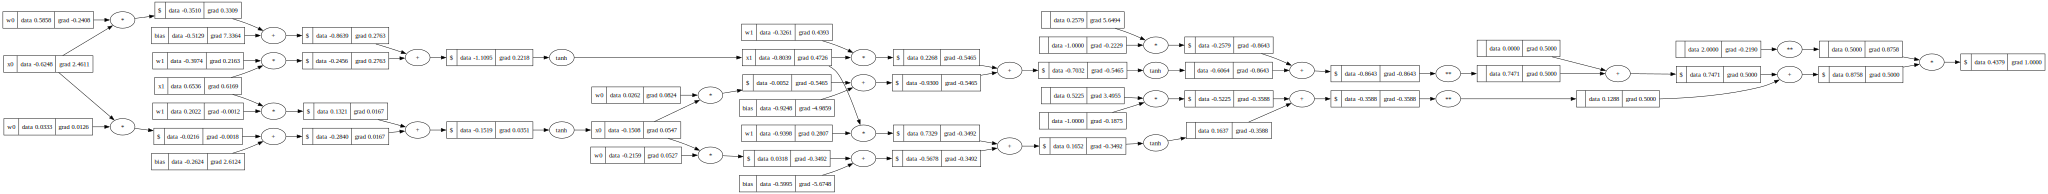

In [64]:
draw_dot(nn.loss)